# ResNet18 Implementation

## Importing Libraries

In [36]:
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Layer
from typing import Tuple, Union
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import resnets as rn
import pandas as pd
import numpy as np
import os

## Set hyperparameters

In [37]:
train_path = "fmd dataset/Train"
test_path = "fmd dataset/Test"
val_path = "fmd dataset/Validation"

seed = 0
image_size = 100
channels = 3
validation_split = 0.2
batch_size = 32
num_epochs = 30
learning_rate = 0.00001
early_stop_patience = 10
classes = ['WithMask', 'WithoutMask']

In [38]:
classes = next(os.walk(train_path))[1]
print(classes)

['WithMask', 'WithoutMask']


## Create training, validation and test datasets

In [39]:
train = image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True
)

validation = image_dataset_from_directory(
    directory=val_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    batch_size=batch_size,
    image_size=(image_size, image_size),
    shuffle=False
)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


## ResNet-18 Architecture (Utilizing resnets Library)

In [40]:
def ResNet18(
    input_shape: Tuple[int, int, int],
    output_units=1000,
    include_top=True,
    after_input: Union[Sequential, Layer, None] = None,
    normalize=False,
    kernel_regularizer: Union[Regularizer, None] = None,
    kernel_initializer="he_uniform",
    flatten=False,
    dropout_rate=0.0,
) -> Model:

    return rn.ResNet(
        input_shape,
        (2, 2, 2, 2),
        "small",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )

## Custom architecture with Dense and Dropout Layers

In [41]:
optimizer = Adam(learning_rate=learning_rate)
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = ResNet18(
    (image_size, image_size, channels),
    include_top=False,
    normalize=True,
    flatten=True,
    dropout_rate=0.2
)

# Apply CNN Headers on top of the base model
xin = model.output
xout = Dense(4096, activation='relu')(xin)
xout = Dropout(0.5)(xout)
xout = Dense(2048, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(1024, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(512, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(256, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(128, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(64, activation='relu')(xout)
xout = Dropout(0.5)(xout)
xout = Dense(len(classes), activation='softmax')(xout)

# Combine the base model and the CNN headers
detector = Model(inputs=model.input, outputs=xout)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=early_stop_patience,
    restore_best_weights=True
)

In [42]:
detector.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 100, 100, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 47, 47, 64)   9472        ['rescaling_2[0][0]']            
                                                                                                  
 batch_normalization_40 (BatchN  (None, 47, 47, 64)  256         ['conv2d_40[0][0]']        

## Checking Cudas

In [43]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Training on Cudas if available

In [44]:
# moving tensorflow to GPU
with tf.device('/GPU:0'):
    detector.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    dmodel = detector.fit(train, validation_data=validation, epochs=num_epochs)

Epoch 1/30


2023-05-05 16:10:05.949376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-05-05 16:10:05.949936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


313/313 [==============================] - ETA: 0s - loss: 1.8331 - sparse_categorical_accuracy: 0.4974

2023-05-05 16:10:20.283040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [800]
	 [[{{node Placeholder/_0}}]]
2023-05-05 16:10:20.283279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [800]
	 [[{{node Placeholder/_0}}]]


313/313 [==============================] - 15s 18ms/step - loss: 1.8331 - sparse_categorical_accuracy: 0.4974 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.5688
Epoch 2/30
313/313 [==============================] - 5s 17ms/step - loss: 1.2144 - sparse_categorical_accuracy: 0.5059 - val_loss: 0.6757 - val_sparse_categorical_accuracy: 0.6388
Epoch 3/30
313/313 [==============================] - 5s 16ms/step - loss: 1.0242 - sparse_categorical_accuracy: 0.5152 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.7287
Epoch 4/30
313/313 [==============================] - 5s 17ms/step - loss: 0.8995 - sparse_categorical_accuracy: 0.5251 - val_loss: 0.6642 - val_sparse_categorical_accuracy: 0.7538
Epoch 5/30
313/313 [==============================] - 5s 17ms/step - loss: 0.8353 - sparse_categorical_accuracy: 0.5310 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.7538
Epoch 6/30
313/313 [==============================] - 5s 16ms/step - loss: 0.7856 - sparse_categorical_ac

## Plotting training progress

<Axes: >

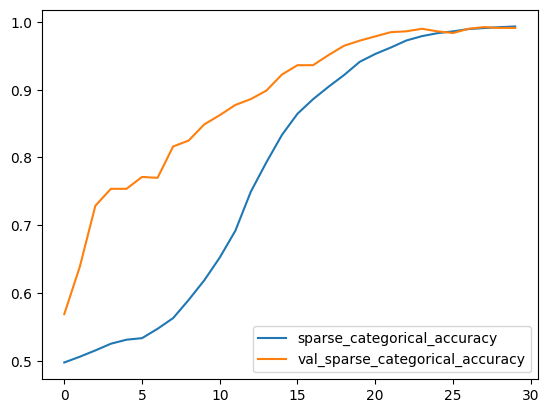

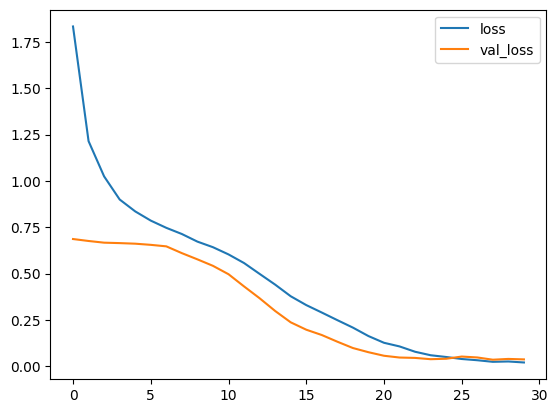

In [45]:
loss_curve = pd.DataFrame(dmodel.history)

loss_curve[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
loss_curve[["loss", "val_loss"]].plot()

## Predict from the above trained model

In [46]:
y_true = []
y_pred = []

with tf.device('/GPU:0'):
    for x_test_batch, y_test_batch in test:
        y_true.append(y_test_batch)
        predictions = detector.predict(x_test_batch, verbose=0)
        y_pred.append(np.argmax(predictions, axis=1))

y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

2023-05-05 16:12:52.336448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [992]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:12:52.336642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [992]
	 [[{{node Placeholder/_4}}]]


## Visualizing the Results

2023-05-05 16:17:06.186735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:17:06.187381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_4}}]]


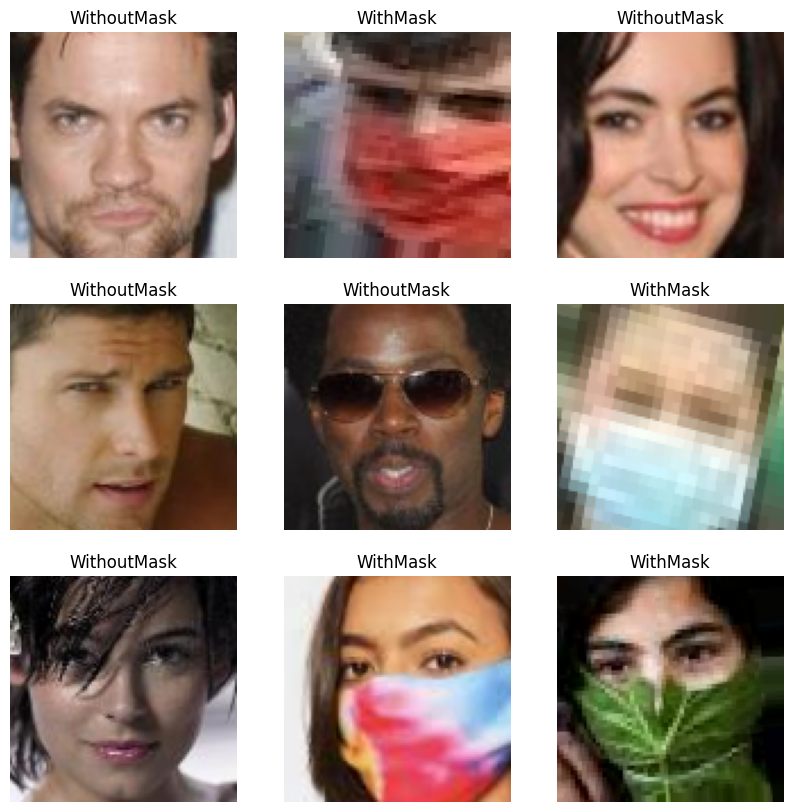

In [63]:
# Visualize the results on test dataset for some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[y_pred[i]])
    plt.axis("off")

## Evaluation of Model

In [48]:
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

              precision    recall  f1-score   support

    WithMask     0.9957    0.9669    0.9811       483
 WithoutMask     0.9694    0.9961    0.9826       509

    accuracy                         0.9819       992
   macro avg     0.9826    0.9815    0.9818       992
weighted avg     0.9822    0.9819    0.9818       992



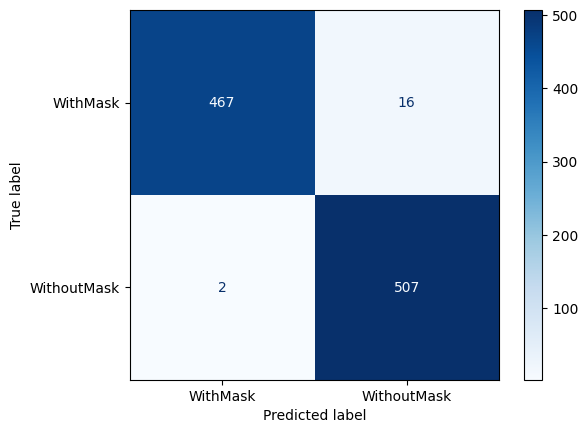

In [49]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Optimizing the model for Embedded Systems and Mobile Phones using TensorFlow Lite

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('Resnet18.tflite', 'wb') as f:
    f.write(tflite_model)

2023-05-05 16:12:57.070092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4608]
	 [[{{node inputs}}]]
2023-05-05 16:12:58.456363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4608]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /tmp/tmposf87at8/assets


INFO:tensorflow:Assets written to: /tmp/tmposf87at8/assets
2023-05-05 16:13:02.046833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-05 16:13:02.046867: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-05 16:13:02.053191: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmposf87at8
2023-05-05 16:13:02.062465: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-05 16:13:02.062478: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmposf87at8
2023-05-05 16:13:02.081250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-05 16:13:02.086178: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-05 16:13:02.234545: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [56]:
# Use the model
interpreter = tf.lite.Interpreter(model_path='Resnet18.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

[{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 100, 100,   3], dtype=int32), 'shape_signature': array([ -1, 100, 100,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 71, 'shape': array([   1, 4608], dtype=int32), 'shape_signature': array([  -1, 4608], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
